# Fairness Calibration Process for Reducing PR Disparity

In this file, the main task is to perform a fairness calibration process to reduce Precision Recall (PR) disparity across models and datasets, ensuring that the prediction scores across different demographic groups are more equitable. This is achieved by calculating empirical quantile functions (EQFs) and cumulative distribution functions (CDFs) for sensitive and non-sensitive groups, which are then used to generate fair predictions. The calibrated scores are saved in a results dictionary called `RES`, which will later be used for plotting and comparing the metrics before and after the calibration process.

The calibration process begins by loading various datasets and model prediction scores, then evaluating metrics such as Disparate Impact (DP), Equal Opportunity (EO), and Equalized Odds (EOD) before calibration. Fairness-related objects like EQFs and CDFs are computed for both sensitive and non-sensitive groups to capture the score distributions and relative quantiles for these groups. The predictions are then calibrated using these fairness objects, introducing random jitter to ensure values do not overlap exactly, thereby mitigating PR disparities between demographic groups. The calibrated predictions are saved in a new column for comparison.

After calibration, metrics are recalculated to assess how effectively the PR disparities have been minimized. The metrics before and after the calibration are stored in the `RES` dictionary for each model and dataset combination, allowing detailed analysis of the effect of the fairness adjustment. The results include values for DP, EO, EOD, and AUC, which help in understanding the fairness improvements and maintaining predictive performance. These metrics and results are crucial for demonstrating the impact of calibration on reducing biases while preserving the accuracy of the models.






--- 
## 1- Calibration Analysis
The next code performs a comprehensive fairness analysis of different models across various datasets.
It calculates fairness metrics before and after calibration, which includes evaluating metrics like
Demographic Parity (DP), Equal Opportunity (EO), Equalized Odds (EOD), and AUC (Area Under Curve).
The fairness calibration process adjusts prediction scores to reduce bias, as seen by comparing
metrics before and after calibration.

### Key Analysis Points:
1. **Loading Data**: Test data, prediction scores, and sensitive attributes are loaded for each task.
2. **Metrics Before Calibration**: The initial fairness metrics are calculated to establish a baseline.
3. **Calibration with Jitter**: Calibration adds jitter to avoid score overlap, promoting score differentiation.
4. **Fairness Estimation**: The fairness objects are used to obtain calibrated scores for both sensitive
   and non-sensitive groups, promoting equitable treatment.
5. **Metrics After Calibration**: Post-calibration metrics are computed to evaluate the effectiveness
   of the fairness adjustment.


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from fairness import *
from Calibrate import *
from Calibrate import _stats_calibrate

# ## Load Sensitive Attribute Dictionary
# Load the sensitive attribute dictionary for the test set, which contains information on protected attributes for different tasks.
with open('saved_params/sens_attr_dict_test.pkl', 'rb') as file:
    sens_attr_dict_test = pickle.load(file)

# ## Initialize Results Dictionary
# This dictionary will store fairness metrics for each model and task before and after fairness calibration.
RES = {}
RES['m2'] = {}
path_base = os.getcwd()  # Get current working directory

# ## Define Tasks and Models
# Define the datasets (tasks) and models to evaluate fairness performance on.
tasks = ['Fodors-Zagat', 'DBLP-GoogleScholar', 'iTunes-Amazon', 'Walmart-Amazon', 'Amazon-Google', 'Beer', 'DBLP-ACM']
models = ['deepmatcher', 'DITTO', 'EMTransformer', 'HierGAT', 'HierMatcher']

# ## Fairness Metrics Analysis
# Loop through each model and dataset to compute metrics before and after applying fairness calibration.
for model in models:
    RES['m2'][model] = {}
    for task in tasks:
        # Initialize metrics for each task before and after calibration
        RES['m2'][model][task] = {
            'before': {'DP': 0, 'EO': 0, 'EOD': 0, 'AUC': 0},
            'after': {'DP': 0, 'EO': 0, 'EOD': 0, 'AUC': 0}
        }

        # ### Load Test Data and Prediction Scores
        df_test = pd.read_csv(path_base + '/DataDir/' + task + '/test.csv')
        scores_test = pd.read_csv(path_base + '/scores/' + task + '_' + model + '/score_test.csv')
        sens_test = sens_attr_dict_test[task]  # Get sensitive attribute information for the test set

        # Identify the prediction column: either probability scores or binary labels
        for x in list(scores_test.columns):
            if len(np.unique(scores_test[x])) > 2:
                prob_test = scores_test[x]  # Assign probability scores if column has continuous values
            else:
                y_test = scores_test[x]  # Assign binary labels if column has binary values

        # ### Calculate Fairness Metrics Before Calibration
        print('Before:')
        DSP_EOD, DSP_EO, DSP_DP, auc_all, Frac = _stats_calibrate(sens_test, prob_test, y_test)
        print(task, model, round(DSP_DP, 2), round(DSP_EO, 2), round(DSP_EOD, 2), round(auc_all, 2))
        RES['m2'][model][task]['before'] = {'DP': DSP_DP, 'EO': DSP_EO, 'EOD': DSP_EOD, 'AUC': auc_all}

        # ### Fairness Calibration - Adding Jitter to Scores
        # Add a small jitter to avoid exact overlaps in prediction scores, which can aid in calibration.
        jitter = 0.000001
        prob_test2 = prob_test + np.random.uniform(-jitter, jitter, prob_test.shape)

        # ### Fairness Estimation
        # Get fairness objects for non-sensitive and sensitive groups based on the modified scores.
        p1, e1, q1 = get_fairness_objects(
            sens_test,
            np.array(prob_test2[sens_test == 0]),  # Scores for non-sensitive group
            np.array(prob_test2[sens_test == 1])   # Scores for sensitive group
        )

        # Calculate fair estimates for non-sensitive and sensitive groups
        fair_nonsensitive, fair_sensitive = get_fair_estimation(
            p1, e1, q1,
            (np.array(prob_test2[sens_test == 0])).reshape(-1,),
            (np.array(prob_test2[sens_test == 1])).reshape(-1,),
            jitter=jitter
        )

        # ### Store Calibrated Predictions
        # Store fair-calibrated estimates in a new DataFrame column
        pred_fair = pd.DataFrame(prob_test.copy())
        pred_fair['calibrated'] = 0.0
        pred_fair.loc[sens_test == 1, 'calibrated'] = fair_sensitive
        pred_fair.loc[sens_test == 0, 'calibrated'] = fair_nonsensitive

        # Normalize calibrated predictions to ensure values are within the [0, 1] range
        if (np.sum(pred_fair['calibrated'] < 0) + np.sum(pred_fair['calibrated'] > 1)) > 0:
            min_val = pred_fair['calibrated'].min()
            pred_fair['calibrated'] = pred_fair['calibrated'] - min_val
            max_val = pred_fair['calibrated'].max()
            pred_fair['calibrated'] = pred_fair['calibrated'] / max_val

        # ### Calculate Fairness Metrics After Calibration
        print('After:')
        DSP_EOD, DSP_EO, DSP_DP, auc_all, Frac = _stats_calibrate(sens_test, pred_fair['calibrated'], y_test)
        print(task, model, round(DSP_DP, 2), round(DSP_EO, 2), round(DSP_EOD, 2), round(auc_all, 2))
        RES['m2'][model][task]['after'] = {'DP': DSP_DP, 'EO': DSP_EO, 'EOD': DSP_EOD, 'AUC': auc_all}

        print()  # Print an empty line for better readability

# ## Save Results
# Uncomment the lines below to save the results dictionary for future reference.
# with open('saved_params/repair_result.pkl', 'wb') as file:
#     pickle.dump(RES, file)




Before:
Fodors-Zagat deepmatcher 2.86 5.51 5.51 100.0
After:
Fodors-Zagat deepmatcher 0.72 8.07 8.07 99.89

Before:
DBLP-GoogleScholar deepmatcher 6.15 11.53 11.53 98.41
After:
DBLP-GoogleScholar deepmatcher 0.07 5.03 5.03 98.28

Before:
iTunes-Amazon deepmatcher 13.84 17.98 17.98 96.97
After:
iTunes-Amazon deepmatcher 0.65 11.55 11.55 97.56

Before:
Walmart-Amazon deepmatcher 3.74 13.8 13.8 82.4
After:
Walmart-Amazon deepmatcher 0.22 5.42 5.42 82.28

Before:
Amazon-Google deepmatcher 8.94 4.36 4.36 89.02
After:
Amazon-Google deepmatcher 0.09 14.38 14.38 88.11

Before:
Beer deepmatcher 25.77 23.0 23.0 95.73
After:
Beer deepmatcher 0.67 27.61 27.61 88.87

Before:
DBLP-ACM deepmatcher 3.63 1.55 1.55 99.57
After:
DBLP-ACM deepmatcher 0.09 5.16 5.16 99.48

Before:
Fodors-Zagat DITTO 3.09 7.99 7.99 99.97
After:
Fodors-Zagat DITTO 0.96 9.58 9.58 99.84

Before:
DBLP-GoogleScholar DITTO 5.8 4.86 4.86 99.7
After:
DBLP-GoogleScholar DITTO 0.07 2.94 2.94 99.59

Before:
iTunes-Amazon DITTO 10.75 2

-----

## 2- plots of comparison for all methods and datas
### Description:

This below script aims to visualize the fairness performance of multiple machine learning models on various entity matching tasks. The `plot_bars()` function generates bar plots to compare the performance of each model before and after applying a fairness intervention. 

- The script starts by loading a pre-saved dictionary (`RES`) that contains performance metrics for different models on several entity matching tasks. The metrics are loaded from a pickle file (`repair_result.pkl`).

- The `plot_bars()` function is used to generate bar charts for each task and metric ('AUC', 'EO', 'EOD'). The bars represent the model's performance before and after the fairness intervention.
  - The function takes in the task name, metric name, y-axis label, and optional y-axis limits.
  - Different colors and edge styles are used for 'before' and 'after' bars to help differentiate the two periods.

- Finally, the script iterates over the tasks and generates bar charts for AUC, EO disparity, and EOD for each task, saving the plots to the `FIGURES/` directory for further analysis.



In [8]:
import matplotlib.pyplot as plt
from fig_params import *

# Load the repair results from the pickle file
with open('saved_params/repair_result.pkl', 'rb') as file:
    RES = pickle.load(file)

# Define the list of tasks and models
tasks = ['Fodors-Zagat', 'DBLP-GoogleScholar', 'iTunes-Amazon', 'Walmart-Amazon', 'Amazon-Google', 'Beer', 'DBLP-ACM']
models = ['deepmatcher', 'DITTO', 'HierGAT', 'EMTransformer', 'HierMatcher']

def plot_bars(task, metric, ylabel, ylim=None):
    """
    Plot bar charts for the specified metric for different models before and after applying the fairness repair.
    
    Parameters:
    - task: The specific matching task to plot.
    - metric: The evaluation metric (e.g., 'AUC', 'EO', 'EOD').
    - ylabel: The label for the y-axis.
    - ylim: Optional y-axis limits for better visualization.
    """
    # Define x-axis labels and positions
    x_labels = ['Deep\nMatcher', 'DITTO', 'HierGAT', 'EMTran', 'Hmatch']  # Model names for x-axis labels
    x = np.arange(len(x_labels))
    bar_fig_size = (15, 9)  # Size of the bar plot figure

    # Initialize figure with specified size
    plt.figure(figsize=bar_fig_size)
    L = bar_border_l  # Line width for bar borders
    bar_width = 0.4  # Width of each bar in the bar plot

    # Iterate over the 'before' and 'after' periods to create bars
    for period, color, edge_color, offset, label in zip(
        ['before', 'after'],
        ['#CC79A7', '#009E73'],  # Colors for the 'before' and 'after' bars
        ['#8A3F5B', '#003D3D'],  # Edge colors for the 'before' and 'after' bars
        [-bar_width / 2 - 0.004, bar_width / 2 + 0.004],  # Offset positions for the bars
        ['Before', 'After']  # Labels for the legend
    ):
        # Collect metric values for each model
        Y = [RES['m2'][model][task][period][metric] for model in models]
        
        # Plot bars with specified color, alpha, and edge settings
        bars = plt.bar(x + offset, Y, width=bar_width, color=color, alpha=fig_alpha, edgecolor=None, label=label)
        for bar in bars:
            bar.set_edgecolor(edge_color)  # Set edge color for each bar
            bar.set_linewidth(L)  # Set line width for each bar
            yval = bar.get_height()  # Get the height of the bar for annotation
            # Add text annotation above each bar
            plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}' if yval != 100 else f'{yval:.0f}',
                     ha='center', va='bottom', fontsize=20)

    # Set axis properties
    plt.xticks(x, x_labels, fontsize=bar_xax_F, rotation=0)  # Set x-axis labels
    plt.yticks(fontsize=bar_yax_F)  # Set y-axis tick font size
    plt.tick_params(axis='y', which='both', length=tick_l, width=tick_w)  # Customize y-axis tick parameters
    plt.tick_params(axis='x', which='both', length=tick_l_bar, width=tick_w_bar)  # Customize x-axis tick parameters
    plt.ylabel(ylabel, fontsize=bar_yax_F)  # Set y-axis label
    if ylim:
        plt.ylim(ylim)  # Set y-axis limits if provided

    # Add legend and title
    if ylabel == 'AUC':
        plt.legend(fontsize=bar_legend_F - 10, loc='lower left')  # Legend location for AUC plots
    else:
        plt.legend(fontsize=bar_legend_F - 10, loc='best')  # Legend location for other plots

    plt.title(task, fontsize=40)  # Set title for the plot
    plt.tight_layout()  # Adjust layout for better spacing
    plt.savefig(f'FIGURES/{metric}_{task}.pdf')  # Save the figure to a file
    plt.close()  # Close the figure to free memory

# Iterate over each task and plot the metrics
for task in tasks:
    # Plot AUC metric
    plot_bars(task, 'AUC', 'AUC', ylim=[50, 103])
    # Plot EO metric
    plot_bars(task, 'EO', 'EO disparity', ylim={'DBLP-ACM': [0, 10], 'Amazon-Google': [0, 41], 'Beer': [0, 52], 'Walmart-Amazon': [0, 16.5], 'Fodors-Zagat': [0, 12.5]}.get(task, None))
    # Plot EOD metric
    plot_bars(task, 'EOD', 'EOD', ylim={'DBLP-ACM': [0, 10], 'Beer': [0, 64], 'Walmart-Amazon': [0, 16.5], 'Amazon-Google': [0, 42]}.get(task, None))




---
## 3- plot a detailed example

This next script evaluates the fairness of a machine learning model before and after applying a calibration process to reduce bias. The steps are as follows:

1. **Initial Setup**:
   - Load sensitive attribute information and test dataset for the specified task and model.
   - Load model predictions and ground-truth labels.

2. **Fairness Metrics Before Calibration**:
   - Calculate the initial fairness metrics (Equal Opportunity Difference, Equal Opportunity, Demographic Parity, and AUC) before calibration.
   - Print these metrics to understand the initial state.

3. **Calibration Process**:
   - Add small random jitter to the prediction probabilities to avoid numerical issues.
   - Split the data into sensitive and non-sensitive groups and estimate fair scores for each group using a calibration method.
   - Store calibrated scores in a new DataFrame and ensure that values are within a valid probability range [0, 1].

4. **Fairness Metrics After Calibration**:
   - Calculate and print the fairness metrics after applying calibration.
   - This comparison helps to evaluate the effectiveness of the calibration in reducing bias while maintaining model performance.

The calibrated probabilities are expected to result in a more fair model, with reduced disparities in metrics such as Demographic Parity and Equal Opportunity.




In [ ]:

# ---- Load Sensitivity Attributes and Data Setup ----
# Load the sensitive attribute data for testing from the pickle file
with open('saved_params/sens_attr_dict_test.pkl', 'rb') as file:
    sens_attr_dict_test = pickle.load(file)

# Initialize variables
result_dict = {}
path_base = os.getcwd()

# Define the specific task and model to evaluate
task = 'Amazon-Google'
model = 'HierGAT'

# Load test dataset and prediction scores
df_test = pd.read_csv(f'{path_base}/DataDir/{task}/test.csv')
scores_test = pd.read_csv(f'{path_base}/scores/{task}_{model}/score_test.csv')
sens_test = sens_attr_dict_test[task]

# Extract probabilities and ground-truth labels from score data
for x in list(scores_test.columns):
    if len(np.unique(scores_test[x])) > 2:  # Probabilities (continuous values)
        prob_test = scores_test[x]
    else:  # Binary labels (0 or 1)
        y_test = scores_test[x]

# ---- Fairness Metrics Before Calibration ----
DSP_EOD, DSP_EO, DSP_DP, auc_all, Frac = _stats_calibrate(sens_test, prob_test, y_test)

# ---- Calibration Process ----
# Add jitter to the probability scores to avoid exact duplicates
jitter = 0.000001
prob_test2 = prob_test + np.random.uniform(-jitter, jitter, prob_test.shape)

# Get fairness-related probability distributions for sensitive and non-sensitive groups
p1, e1, q1 = get_fairness_objects(
    sens_test,
    np.array(prob_test2[sens_test == 0]),  # non-sensitive group (0)
    np.array(prob_test2[sens_test == 1])   # sensitive group (1)
)

# Estimate fair probabilities for both groups
fair_nonsensitive, fair_sensitive = get_fair_estimation(
    p1, e1, q1,
    np.array(prob_test2[sens_test == 0]).reshape(-1,),
    np.array(prob_test2[sens_test == 1]).reshape(-1,),
    jitter=jitter
)

# Create a new DataFrame to store calibrated probabilities
pred_fair = pd.DataFrame(prob_test.copy())
pred_fair['calibrated'] = 0.0
pred_fair.loc[sens_test == 1, 'calibrated'] = fair_sensitive
pred_fair.loc[sens_test == 0, 'calibrated'] = fair_nonsensitive

# Normalize calibrated probabilities if any value is out of range [0, 1]
if (np.sum(pred_fair['calibrated'] < 0) + np.sum(pred_fair['calibrated'] > 1)) > 0:
    min_val = pred_fair['calibrated'].min()
    pred_fair['calibrated'] = pred_fair['calibrated'] - min_val
    max_val = pred_fair['calibrated'].max()
    pred_fair['calibrated'] = pred_fair['calibrated'] / max_val

# ---- Fairness Metrics After Calibration ----
DSP_EOD2, DSP_EO2, DSP_DP2, auc_all2, Frac = _stats_calibrate(sens_test, pred_fair['calibrated'], y_test)








### next scrip analyze


- **Initial Setup**: Predictions from the model are loaded, and various fairness metrics are calculated.
- **Fairness Calculations**: The script iterates over different thresholds to calculate metrics such as EO, EOD, and DP for both calibrated and uncalibrated models.
- **Plotting**: The script generates four plots:
  - **EO Plot**: Comparison of EO values before and after calibration.
  - **EOD Plot**: Comparison of EOD values before and after calibration.
  - **DP Plot**: Comparison of DP values before and after calibration.
  - **AUC Plot**: Plot of the Receiver Operating Characteristic (ROC) curves before and after calibration.

The generated plots are saved in the `FIGURES` directory, providing visual insights into how calibration affects model fairness across different metrics.


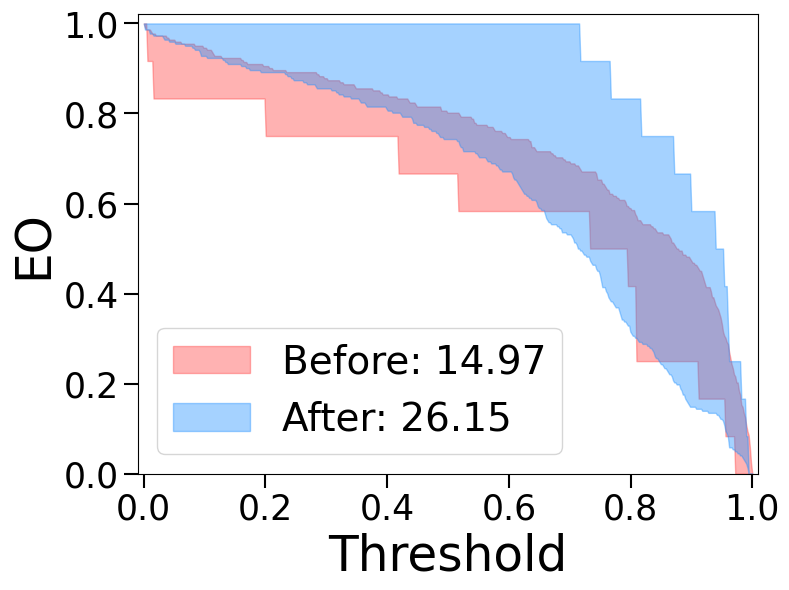

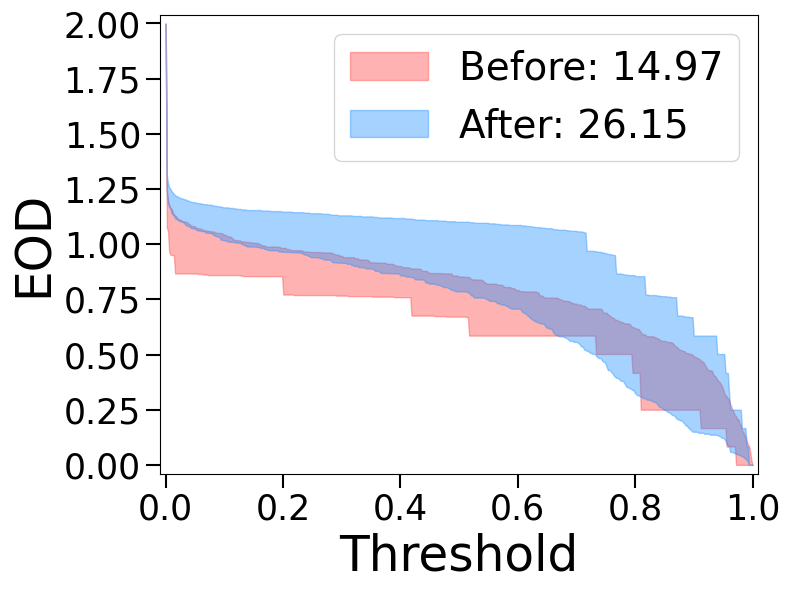

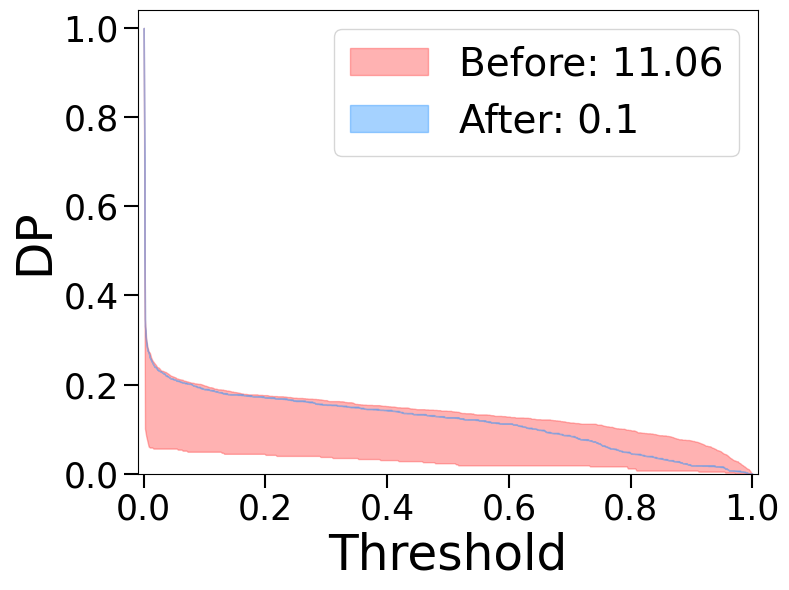

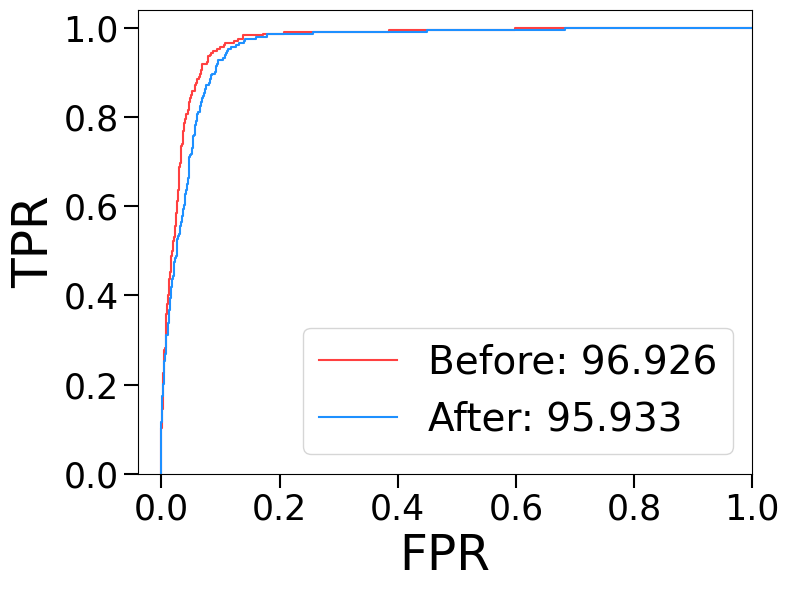

In [10]:

# ---- Load Fairness Predictions and Initial Setup ----
# Load the fairness-calibrated predictions from the pickle file
res = np.array(list(pred_fair['calibrated']))

# Extract different fairness and model-related variables from the loaded data
score_optimal_Eop, score_optimal_Eodd, score_optimal_PR, model, dataset, sens_attr, y_true, score = res, res, res, model, task, sens_test, np.array(y_test), np.array(pred_fair[pred_fair.columns[0]])

# Set the y-score values based on the original score
y_score = score

# ---- Initial Fairness Calculations ----
# Calculate initial fairness metrics for the model before calibration
Eodd_disp_init = calc_EO_disp(sens_attr, y_true, y_score)
auc_init = roc_auc_score(y_true, y_score)
PR_disp_init = calc_DP_PR(sens_attr, y_true, y_score)
Eop_disp_init = calc_DP_TPR(sens_attr, y_true, y_score)

# Set the threshold range for further evaluations
range = np.linspace(0, 1, 500)

# ---- Fairness Metrics for Optimal Eop Score ----
# Calculate fairness metrics for the optimal Eop-calibrated score
Eop_disp = calc_DP_TPR(sens_attr, y_true, score_optimal_Eop)
auc_Eop = roc_auc_score(y_true, score_optimal_Eop)

# Iterate over thresholds to calculate Equal Opportunity (EO) disparity for group 1 and group 2 before and after calibration
E_op_g1, E_op_g2 = [], []
for TH in range:
    y_pred = np.array([1 if score > TH else 0 for score in y_score])
    E_op_g1, E_op_g2, _, _ = E_make(E_op_g1, E_op_g2, [], [], y_true, y_pred, sens_attr)

E_op_g1_calib, E_op_g2_calib = [], []
for TH in range:
    y_pred = np.array([1 if score > TH else 0 for score in score_optimal_Eop])
    E_op_g1_calib, E_op_g2_calib, _, _ = E_make(E_op_g1_calib, E_op_g2_calib, [], [], y_true, y_pred, sens_attr)

# Calculate the AUC values before and after calibration for optimal Eop
AUC_init, _, _ = AUC_make(y_true, y_score, sens_attr)
AUC_Eop, _, _ = AUC_make(y_true, score_optimal_Eop, sens_attr)

# ---- Fairness Metrics for Optimal Eodd Score ----
# Calculate fairness metrics for the optimal Eodd-calibrated score
Eodd_disp = calc_EO_disp(sens_attr, y_true, score_optimal_Eodd)
auc_Eodd = roc_auc_score(y_true, score_optimal_Eodd)
AUC_Eod, _, _ = AUC_make(y_true, score_optimal_Eodd, sens_attr)

# Iterate over thresholds to calculate Equal Opportunity Difference (EOD) disparity before and after calibration
E_od_g1, E_od_g2 = [], []
for TH in range:
    y_pred = np.array([1 if score > TH else 0 for score in y_score])
    _, _, E_od_g1, E_od_g2 = E_make([], [], E_od_g1, E_od_g2, y_true, y_pred, sens_attr)

E_od_g1_calib, E_od_g2_calib = [], []
for TH in range:
    y_pred = np.array([1 if score > TH else 0 for score in score_optimal_Eodd])
    _, _, E_od_g1_calib, E_od_g2_calib = E_make([], [], E_od_g1_calib, E_od_g2_calib, y_true, y_pred, sens_attr)

# ---- Fairness Metrics for Optimal PR Score ----
# Calculate fairness metrics for the optimal PR-calibrated score
PR_disp = calc_DP_PR(sens_attr, y_true, score_optimal_PR)
auc_PR = roc_auc_score(y_true, score_optimal_PR)
AUC_PR, _, _ = AUC_make(y_true, score_optimal_PR, sens_attr)

# Iterate over thresholds to calculate demographic parity (PR) disparity before and after calibration
PR_g1, PR_g2 = [], []
for TH in range:
    y_pred = np.array([1 if score > TH else 0 for score in y_score])
    _, PR_g1, PR_g2 = PR_make([], PR_g1, PR_g2, y_true, y_pred, sens_attr)

PR_g1_calib, PR_g2_calib = [], []
for TH in range:
    y_pred = np.array([1 if score > TH else 0 for score in score_optimal_PR])
    _, PR_g1_calib, PR_g2_calib = PR_make([], PR_g1_calib, PR_g2_calib, y_true, y_pred, sens_attr)

# ---- Plotting Results ----
# Set up plot configurations and create figures for different metrics
L = 1.5
F = 25
F_legend = 28
F_title = 35
size = (8, 6)

# Function to plot results

def plot_results(y_values_before, y_values_after, ylabel, filename, ylim=None, legend_loc='best'):
    plt.figure(figsize=size)
    plt.xticks(fontsize=F)
    plt.yticks(fontsize=F)
    plt.fill_between(range, y_values_before[0], y_values_before[1], color='#FF4040', alpha=0.4, label='Before: ' + str(round(y_values_before[2], 2)))
    plt.fill_between(range, y_values_after[0], y_values_after[1], color='#1E90FF', alpha=0.4, label='After: ' + str(round(y_values_after[2], 2)))
    plt.ylabel(ylabel, fontsize=F_title)
    plt.xlabel('Threshold', fontsize=F_title)
    if ylim:
        plt.ylim(ylim)
    plt.xlim([-0.01, 1.01])
    plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)
    plt.tight_layout()
    plt.legend(loc=legend_loc, fontsize=F_legend)
    plt.savefig(f'FIGURES/{filename}_{model}_{dataset}_alg1_example.pdf')

# Plot Metrics before and after calibration
plot_results((E_op_g1, E_op_g2, DSP_EO), (E_op_g1_calib, E_op_g2_calib, DSP_EO2), 'EO', 'EO', ylim=[0, 1.02], legend_loc='lower left')
plot_results((E_od_g1, E_od_g2, DSP_EOD), (E_od_g1_calib, E_od_g2_calib, DSP_EOD2), 'EOD', 'EOD', ylim=[-0.04, 2.04])
plot_results((PR_g2, PR_g1, DSP_DP), (PR_g1_calib, PR_g2_calib, DSP_DP2), 'DP', 'PR', ylim=[0, 1.04])

# Plot AUC before and after calibration
plt.figure(figsize=size)
plt.xticks(fontsize=F)
plt.yticks(fontsize=F)
plt.plot(AUC_init[0], AUC_init[1], label='Before: ' + str(round(100 * auc_init, 3)), color='#FF4040', linewidth=L)
plt.plot(AUC_Eod[0], AUC_Eod[1], label='After: ' + str(round(100 * auc_Eop, 3)), color='#1E90FF', linewidth=L)
plt.legend(fontsize=F_legend, loc='best')
plt.xlabel('FPR', fontsize=F_title)
plt.ylabel('TPR', fontsize=F_title)
plt.ylim([0, 1.04])
plt.xlim([0 - 0.04, 1])
plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)
plt.tight_layout()
plt.savefig('FIGURES/AUC_' + str(model) + '_' + str(dataset) + '_alg1_example.pdf')


